In [114]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,potentialRegression
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma,standartize
from martingale import approx_q,test_traj
from optimize import Run_eval_test,optimize_parallel_new 
from utils import *
import pandas as pd
import copy

In [115]:
dataset = "swiss" # Switch between "eeg" and "susy" 
intercept = False # Do we include the intercept
degree = 1 #order of CV's: 1 or 2 expected
typ = "logistic" #logistic or probit are expected

sampler = {"sampler":"ULA","burn_type":"full","main_type":"full"} # Sampling method

# Switch between "posterior_prob_point", "posterior_prob_mean", "posterior_prob_variance", "posterior_mean"
if typ == "logistic":
    f_type = "sum"
elif typ == "probit":
    f_type = "posterior_prob_mean_probit"

### Loading data

In [116]:
if (dataset == "swiss"):
    data = pd.read_csv("./data/swiss.csv",header=None)
    outliers_inds = np.array([])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "eeg"):   
    data = pd.read_csv("../iZAV_code/data/eeg.csv",header=None)
    outliers_inds = np.array([13179,11509,898,10386])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "pima"):
    data = pd.read_csv("../iZAV_code/data/pima.csv",header=None)
    outliers_inds = np.array([])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "susy"): 
    data = pd.read_csv("data/susy.csv",header=None)
    outliers_inds = np.array([267630])
    Y = data.iloc[:,0]
    X = data.iloc[:,1:]

### Preprocessing data

In [117]:
# Removing the outliers
if (outliers_inds.size!=0):
    X_processed = np.delete(np.asarray(X),outliers_inds,0)
    mask = np.ones(len(Y),dtype = bool)
    mask[outliers_inds] = False
    Y_processed = Y[mask]
    Y_processed = np.asarray(Y_processed)
    X_processed = np.asarray(X_processed)
else:
    Y_processed = np.asarray(Y)
    X_processed = np.asarray(X)

In [118]:
#X_train,X_train = standartize(X_processed,X_processed,intercept=intercept)
#Y_train = Y_processed

In [119]:
X_train = copy.deepcopy(X_processed)
Y_train = copy.deepcopy(Y_processed)
#poor man's normalization
X_train = np.dot(X_train - np.mean(X_train, axis=0), np.diag(1./np.std(X_train, axis=0)))

In [120]:
print(X_train)
print(Y_train)

[[-0.25558323  2.43945206  2.83704322 -0.28973195]
 [-0.78804829 -1.17043716 -0.63638092 -0.91430383]
 [-0.25558323 -1.17043716 -0.63638092 -0.49792258]
 [-0.25558323 -1.17043716 -0.88448265 -1.33068508]
 [ 0.27688183 -1.44812094 -0.63638092  0.6818243 ]
 [ 2.14050953  1.88408449  1.34843287 -0.28973195]
 [ 1.60804448 -1.72580473 -0.63638092 -1.05309758]
 [-1.05428082 -1.44812094 -1.87688955 -1.5388757 ]
 [ 0.0106493  -2.00348852 -0.63638092 -0.84490695]
 [ 0.80934689  0.77334934  0.85222942 -0.1509382 ]
 [ 1.07557942  0.77334934  0.85222942 -1.05309758]
 [ 0.54311436 -1.72580473 -0.88448265 -1.19189133]
 [ 0.80934689  1.88408449 -0.88448265 -1.05309758]
 [-0.52181576 -1.17043716 -0.63638092 -1.19189133]
 [ 0.54311436 -0.61506959 -0.63638092 -1.19189133]
 [-1.05428082 -0.89275337 -0.3882792  -0.08154133]
 [-0.78804829 -0.61506959  0.35602597 -0.84490695]
 [ 0.27688183 -0.61506959 -0.63638092 -0.28973195]
 [ 0.80934689 -1.44812094 -0.88448265 -1.40008195]
 [-0.52181576  0.21798177 -0.14

### Creating potential

In [121]:
# Creating potential
Cur_pot = potentialRegression(Y_train, X_train, typ, print_info = True)
d = Cur_pot.d

### Data generation

In [122]:
N_burn = 1*10**4 # Burn in period
N_train = 5*10**4 # Number of samples on which we optimize
N_test = 1*10**3 # Number of samples
step = 0.1 # Step size
n_traj_train = 5
n_traj_test = 24 # Number of independent MCMC trajectories for test
#f_type = "sum"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 50 #maximal lag order
b_n_train = 10 #lag-window size
b_n_test = int(np.round(N_test**(0.33)))
print(b_n_test)
degree = 1

10


### Generate data

In [123]:
r_seed = 777
traj = np.zeros((n_traj_train,N_train,d),dtype = float)
for i in range(n_traj_train):
    cur_traj = ULA_light(r_seed+i,Cur_pot,step, N_burn, N_train, d, return_noise = False)
    traj[i] = copy.deepcopy(cur_traj)
print(traj.shape)
#traj = np.expand_dims(traj, axis=0)
#rint(traj.shape)

(5, 50000, 4)


In [124]:
inds_arr = np.array([0]) # Taking the second index (not intercept)
params = None    
f_vals = set_function(f_type,traj,inds_arr,params) 
#f_vals = traj[:,:,0]
#f_vals = np.expand_dims(f_vals, axis=2)
print(f_vals.shape)

(5, 50000, 1)


### Evaluate baselines (EVM and ESVM methods)

In [125]:
if sampler["sampler"] == "ULA":
    res = Generate_train(1, sampler, Cur_pot, step, N_burn, N_train, d)
    res = np.asarray(res)
    traj_evm,traj_grad = res[:,0,:,:],res[:,1,:,:]
else:
    raise "You should use ULA!"

ncores =  12


In [126]:
print(traj.shape)
inds_arr = np.array([0])#Taking the second index
params = None
f_vals_evm = set_function(f_type,traj_evm,inds_arr,params)

(5, 50000, 4)


In [127]:
print(f_vals_evm)
print(f_vals)

[[[4.30468234]
  [4.2152753 ]
  [4.92433947]
  ...
  [8.17310485]
  [3.9829394 ]
  [7.56200827]]]
[[[4.2152753 ]
  [4.92433947]
  [6.80072047]
  ...
  [3.9829394 ]
  [7.56200827]
  [3.70378255]]

 [[5.33137383]
  [3.21504365]
  [6.16871108]
  ...
  [4.69707007]
  [7.04347087]
  [7.49368302]]

 [[4.36005174]
  [6.42260106]
  [3.40758546]
  ...
  [6.33404355]
  [4.26520135]
  [6.19060381]]

 [[3.850832  ]
  [6.14932671]
  [5.33544272]
  ...
  [5.37730713]
  [4.15455828]
  [2.47796337]]

 [[6.8287092 ]
  [3.55694098]
  [7.81986687]
  ...
  [5.4085931 ]
  [3.39439312]
  [6.74435202]]]


In [128]:
W_train_spec = construct_ESVM_kernel(N_train,b_n_train) #weight matrix for train
W_test_spec = construct_ESVM_kernel(N_test,b_n_test) #weight matrix for test
opt_structure_train = {
    "W":W_train_spec,
    "n_restarts": 3, # Number of restarts during optimization,
    "sigma": 1.0, # Deviation of starting points
    "tol": 1e-5, # Tolerance (for the norm of gradient)
    "alpha": 0.0, # Ridge penalty for 2nd order control functionals
    "beta": 10000.0 # smoothing parameter in the softmax
}
methods = ["ESVM","EVM"]

In [129]:
coef_dict = optimize_parallel_new(degree,inds_arr,f_vals_evm,traj_evm,traj_grad,opt_structure_train,methods)
print(coef_dict)

2
1 degree optimization terminated succesfully
jacobian at termination: 
[ 1.10439451e-09  9.80884301e-10  7.82155728e-10 -1.43542175e-10]
1 degree optimization terminated succesfully
jacobian at termination: 
[ 1.31658737e-13 -2.17319780e-13  3.88035701e-13 -4.35350227e-13]
{'ESVM': array([[ 0.03970984,  0.05233694, -0.01620616,  0.15887274]]), 'EVM': array([[0.06124098, 0.07375681, 0.02688071, 0.09141553]]), 'LS': [], 'MAX': []}


In [130]:
#Create a dictionary and put respective matrices into it
test_params = {
    "W":W_test_spec,
    "step":step,
    "burn_in":N_burn,
    "n_test":N_test,
    "dim":d
}

nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Run_eval_test, [(i,degree,sampler,methods,inds_arr,Cur_pot,test_params,coef_dict,params,f_type) for i in range (n_traj_test)])
trav.close()

In [131]:
methods_enh = ['Vanilla'] + methods
print(methods_enh)
ints_result = {key: [] for key in methods_enh}
vars_result = {key: [] for key in methods_enh}

['Vanilla', 'ESVM', 'EVM']


In [132]:
for i in range(len(res)):
    for j in range(len(methods_enh)):
        ints_result[methods_enh[j]].append(res[i][0][methods_enh[j]][0])
        vars_result[methods_enh[j]].append(res[i][1][methods_enh[j]][0])
for key in methods_enh:
    ints_result[key] = np.asarray(ints_result[key])
    vars_result[key] = np.asarray(vars_result[key])

### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [133]:
#polynomial coefficients
S_max = 2
coefs_poly = approx_q(traj,f_vals,n_traj_train,lag,S_max)
print(coefs_poly.shape)
coefs_poly_1 = approx_q(traj,f_vals,n_traj_train,lag,1)
print(coefs_poly_1.shape)

dimension =  50000
(250000, 15)
(249995, 15)
(249990, 15)
(249985, 15)
(249980, 15)
(249975, 15)
(249970, 15)
(249965, 15)
(249960, 15)
(249955, 15)
(249950, 15)
(249945, 15)
(249940, 15)
(249935, 15)
(249930, 15)
(249925, 15)
(249920, 15)
(249915, 15)
(249910, 15)
(249905, 15)
(249900, 15)
(249895, 15)
(249890, 15)
(249885, 15)
(249880, 15)
(249875, 15)
(249870, 15)
(249865, 15)
(249860, 15)
(249855, 15)
(249850, 15)
(249845, 15)
(249840, 15)
(249835, 15)
(249830, 15)
(249825, 15)
(249820, 15)
(249815, 15)
(249810, 15)
(249805, 15)
(249800, 15)
(249795, 15)
(249790, 15)
(249785, 15)
(249780, 15)
(249775, 15)
(249770, 15)
(249765, 15)
(249760, 15)
(249755, 15)
(50, 15)
dimension =  50000
(250000, 5)
(249995, 5)
(249990, 5)
(249985, 5)
(249980, 5)
(249975, 5)
(249970, 5)
(249965, 5)
(249960, 5)
(249955, 5)
(249950, 5)
(249945, 5)
(249940, 5)
(249935, 5)
(249930, 5)
(249925, 5)
(249920, 5)
(249915, 5)
(249910, 5)
(249905, 5)
(249900, 5)
(249895, 5)
(249890, 5)
(249885, 5)
(249880, 5)
(24

In [134]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(S_max)
X_features = poly.fit_transform(traj[0])
poly_1 = PolynomialFeatures(1)
X_features_1 = poly_1.fit_transform(traj[0])

In [135]:
print(X_features.shape)

(50000, 15)


Test our regressors

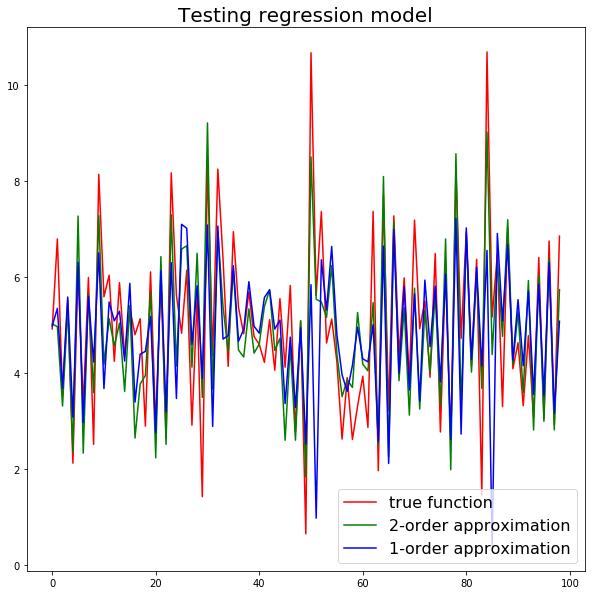

In [139]:
cur_lag = 1
N_pts = 100
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(f_vals[0,cur_lag:N_pts,0],color='r',label='true function')
plt.plot(X_features[:(N_pts-cur_lag),:] @ coefs_poly[cur_lag,:],color='g',label = '2-order approximation')
plt.plot(X_features_1[:(N_pts-cur_lag),:] @ coefs_poly_1[cur_lag,:],color='b',label = '1-order approximation')
plt.legend(loc = 'lower right',fontsize = 16)
plt.show()

In [137]:
print("4-nd order error: ",np.linalg.norm(f_vals[0,cur_lag:N_pts,0]-X_features[:(N_pts-cur_lag),:] @ coefs_poly[cur_lag,:]))
print("1-st order error: ",np.linalg.norm(f_vals[0,cur_lag:N_pts,0]-X_features_1[:(N_pts-cur_lag),:] @ coefs_poly_1[cur_lag,:]))

4-nd order error:  9.624459588089243
1-st order error:  14.035665207096118


In [24]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params) for i in range (n_traj_test)])
trav.close()

In [25]:
res_new = np.asarray(res)
print(res_new.shape)

(24, 2, 1000)


In [26]:
vars_vanilla = np.var(res_new[:,0,:],axis = 0)
vars_adj = np.var(res_new[:,1,:],axis = 0)
#print(vars_vanilla)
#print(vars_adj)
print(np.mean(vars_adj[1:]/vars_vanilla[1:]))

1.0


### Comparison plots

In [27]:
title = ""
labels = ['Vanilla\n ULA', 'ULA \nwith MDCV', 'ULA \nwith EVM','ULA\nwith ESVM']

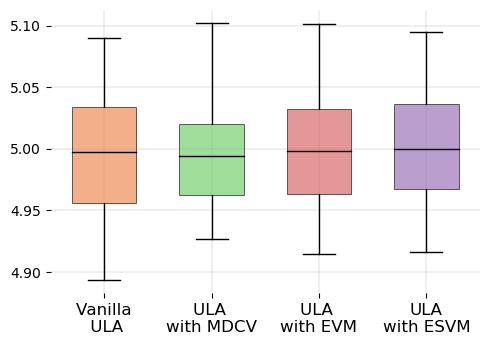

In [28]:
data = [ints_result['Vanilla'][:,0],res_new[:,1,-1],ints_result['EVM'][:,0],ints_result['ESVM'][:,0]] 
boxplot_ind(data, title, labels)

In [29]:
title = ""
labels = ['ULA \nwith MDCV', 'ULA \nwith EVM','ULA\nwith ESVM']

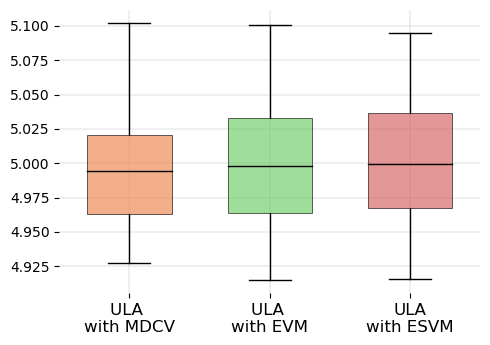

In [30]:
data = [res_new[:,1,-1],ints_result['EVM'][:,0],ints_result['ESVM'][:,0]] 
boxplot_ind(data, title, labels)